# 3. AutoML : Classification des données


<BR>
    
In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [00.configuration](00.configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
- Create an `Experiment` in an existing `Workspace`.
- Configure AutoML using `AutoMLConfig`.
- Train the model using local compute.
- Explore the results.
- Test the best fitted model.


This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.

For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.


<img src="https://www.seewald.at/img/L/digits.gif">


## 0. Documentation Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.0.17


In [2]:
# Mise à jour Azure ML service
#!pip install azureml-sdk[automl,notebooks,explain]

In [3]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [4]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-local-clustering'
project_folder = './sample_projects/automl-local-clustering'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: C:\Users\seretkow\notebooks\Labs Azure ML service\aml_config\config.json


,
SDK version,1.0.17
Workspace Name,MLServiceWorkspace
Resource Group,mlserviceresourcegroup
Location,westeurope
Project Directory,./sample_projects/automl-local-clustering
Experiment Name,automl-local-clustering


## Télémétrie

Opt-in diagnostics for better experience, quality, and security of future releases.

In [5]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [6]:
%%time
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

Wall time: 141 ms


## 4. Configuration AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>balanced_accuracy</i><br><i>average_precision_score_weighted</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in seconds for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

**K-Folds Cross Validation**

Use `n_cross_validations` setting to specify the number of cross validations. The training data set will be randomly split into `n_cross_validations` folds of equal size. During each cross validation round, one of the folds will be used for validation of the model trained on the remaining folds. This process repeats for `n_cross_validations` rounds until each fold is used once as validation set. The average scores across all `cross_validations rounds` will be reported, and the corresponding model will be retrained on the whole training data set.

**Monte Carlo Cross Validation (a.k.a. Repeated Random Sub-Sampling)**

Use `validation_size` to specify the percentage of the training dataset that should be used for validation, and use `n_cross_validations` to specify the number of cross validations. During each cross validation round, a subset of size validation_size will be randomly selected for validation of the model trained on the remaining data. Finally, the average scores across all `n_cross_validations` rounds will be reported, and the corresponding model will be retrained on the whole training data set.

** Métriques disponibles** :<br>`
Accuracy
AUC_weighted
precision_score_weighted
balanced_accuracy
average_precision_score_weighted`


Documentation :
https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### 4.1 Liste des modèles : 

<img src="https://raw.githubusercontent.com/retkowsky/workshop_AzureMLService/master/Liste%20des%20mod%C3%A8les%20AUTOML.jpg" width="800" height="800">

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### 4.2 Configuration

In [7]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 10,
                             iterations = 50,
                             n_cross_validations = 5,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [8]:
%%time
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_ed13b248-6c0d-452d-b8f9-4fbbeef304a8
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   RobustScaler KNN                               100.0000    0:00:09       0.9973    0.9973
         1   StandardScalerWrapper LightGBM                 100.0000    0:00:09       0.9978    0.9978
         2   StandardScalerWrapper LightGBM                 100

In [9]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-local-clustering,AutoML_ed13b248-6c0d-452d-b8f9-4fbbeef304a8,automl,Completed,Link to Azure Portal,Link to Documentation


Optionally, you can continue an interrupted local run by calling `continue_experiment` without the `iterations` parameter, or run more iterations for a completed run by specifying the `iterations` parameter:

#local_run = local_run.continue_experiment(X = X_train, 
                                          y = y_train, 
                                          show_output = True,
                                          iterations = 5)

In [10]:
#local_run = local_run.continue_experiment(X = X_train, y = y_train, show_output = True, iterations = 5)


## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [11]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…


### 6.2 Métriques par itération


In [12]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AUC_macro,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,0.99,...,1.00,0.06,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
AUC_micro,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,0.99,...,1.00,0.43,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
AUC_weighted,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,0.99,...,1.00,0.06,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
accuracy,0.97,0.95,0.96,0.93,0.87,0.97,0.92,0.95,0.93,0.91,...,0.98,0.10,0.96,0.98,0.96,0.97,0.97,0.96,0.97,0.99
average_precision_score_macro,0.99,0.99,0.99,0.97,0.92,1.00,0.96,0.99,0.98,0.96,...,1.00,0.06,0.99,1.00,0.99,0.99,1.00,0.98,1.00,1.00
average_precision_score_micro,0.99,0.99,0.99,0.98,0.92,1.00,0.97,0.99,0.98,0.97,...,1.00,0.08,0.99,1.00,0.99,1.00,1.00,0.98,1.00,1.00
average_precision_score_weighted,0.99,0.99,0.99,0.97,0.92,1.00,0.96,0.99,0.98,0.96,...,0.99,0.06,0.99,1.00,0.99,0.99,1.00,0.98,1.00,1.00
balanced_accuracy,0.97,0.95,0.96,0.93,0.87,0.97,0.91,0.95,0.94,0.91,...,0.98,0.10,0.96,0.98,0.96,0.97,0.97,0.96,0.98,0.99
f1_score_macro,0.96,0.95,0.96,0.93,0.87,0.97,0.91,0.94,0.93,0.91,...,0.98,0.02,0.96,0.98,0.96,0.97,0.97,0.96,0.97,0.99
f1_score_micro,0.97,0.95,0.96,0.93,0.87,0.97,0.92,0.95,0.93,0.91,...,0.98,0.10,0.96,0.98,0.96,0.97,0.97,0.96,0.97,0.99


## 7. Récupération du meilleur modèle

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [13]:
best_run, fitted_model = local_run.get_output()

print(best_run)
print()
print(fitted_model)

Run(Experiment: automl-local-clustering,
Id: AutoML_ed13b248-6c0d-452d-b8f9-4fbbeef304a8_49,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('SVM', Pipeline(memory=None,
     steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('SVCWrapper', SVCWrapper(C=494.1713361323828, cache_size=200, class_weight=None, coef0=0...67, 0.06666666666666667, 0.06666666666666667, 0.2, 0.13333333333333333, 0.2, 0.13333333333333333]))])


### 7.1 Changement de la métrique AutoML


In [14]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Meilleur modèle :")
print(best_run)
print()
print(fitted_model)

Meilleur modèle :
Run(Experiment: automl-local-clustering,
Id: AutoML_ed13b248-6c0d-452d-b8f9-4fbbeef304a8_49,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('SVM', Pipeline(memory=None,
     steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('SVCWrapper', SVCWrapper(C=494.1713361323828, cache_size=200, class_weight=None, coef0=0...67, 0.06666666666666667, 0.06666666666666667, 0.2, 0.13333333333333333, 0.2, 0.13333333333333333]))])


Model from a Specific Iteration
Show the run and the model from the third iteration:

In [15]:
iteration = 3

third_run, third_model = local_run.get_output(iteration = iteration)
print("Modèle 3eme itération :")
print(third_run)
print()
print(third_model)

Modèle 3eme itération :
Run(Experiment: automl-local-clustering,
Id: AutoML_ed13b248-6c0d-452d-b8f9-4fbbeef304a8_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('SparseNormalizer', <automl.client.core.common.model_wrappers.SparseNormalizer object at 0x000002819DFC0208>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x000002819DF94F28>)])


## 8. Application du modèle

### 8.1 Chargement des données

In [16]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

9


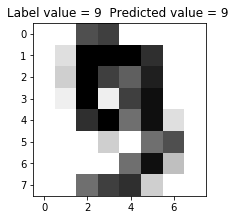

0


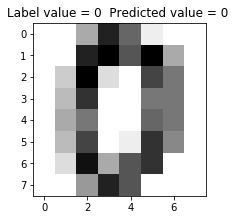

Wall time: 717 ms


In [17]:
%%time
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

> Fin

** Documentation disponible :**
    https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train